# Neural network learns the semantics of Hispanic rap in an unsupervised way
Word2Vec is a two-layer neural network for processing text. It converts it into numerical vectors that other models understand, in word embeddings the semantic relationship between words, rhymes, synonyms, antonyms, etc. is preserved.

This can be done with reviews, comments, books, tweets, and in this case songs; With the vocabulary learned you can apply sentiment analysis and other NLP tasks in research, music, e-commerce, and CRM among others.

We will do the following:
* Import dataset
* Clean dataset
* Train the model using the Gensim implementation
* Export the model and word embeddings


* Predict context by word
* Predict word according to context
* Add and subtract words
* Discard word from the group of words


* Display 2D model

The model can be visualized in 3D using Tensorboard, but lets focus just on 2D in this project: https://stackoverflow.com/questions/50492676/visualize-gensim-word2vec-embeddings-in-tensorboard-projector/50499090

Words are discrete states of data, and we look for the transitional probabilities between them, analyzing neighboring words. In an unsupervised way we find patterns, we keep the mathematical similarity of semantics in vectors.

<img src="window.png"  style="width:1200px;"/>


Assuming we have a vocabulary of 10,000 words, for each word we will create a one-hot vector of 10,000 dimensions, one for each word, with a 1 where the word is and the rest 0s.

The output is also a vector of 10,000 components, for each word, the possibility that another random word appears near it. Neural network architecture:

<img src="skip_gram_net_arch.png"  style="width:800px;"/>


[Practical example](http://methodmatters.blogspot.com/2017/11/using-word2vec-to-analyze-word.html)

[The model explained in detail](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)

[Subsampling and other techniques for large datasets](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/)


## Dataset: 9317 Spanish-language rap song lyrics


In [6]:
import pandas as pd
import unidecode
import string
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim, logging
import gensim.models.word2vec as w2v
import multiprocessing
from sklearn.manifold import TSNE

Logging opcional, y descargamos las stopwords

In [21]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Meysam24zamani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Import dataset
We load the CSV, which contains metadata of all the songs.

In [10]:
dataset = pd.read_csv('lyrics.csv')
dataset.tail()

index                         song  year      artist    genre  \
362571  362232    who-am-i-drinking-tonight  2012  edens-edge  Country   
362572  362233                         liar  2012  edens-edge  Country   
362573  362234                  last-supper  2012  edens-edge  Country   
362574  362235  christ-alone-live-in-studio  2012  edens-edge  Country   
362575  362236                         amen  2012  edens-edge  Country   

                                                   lyrics  
362571  I gotta say\nBoy, after only just a couple of ...  
362572  I helped you find her diamond ring\nYou made m...  
362573  Look at the couple in the corner booth\nLooks ...  
362574  When I fly off this mortal earth\nAnd I'm meas...  
362575  I heard from a friend of a friend of a friend ...

## Clean the dataset and create text corpus
We are only interested in the column with the lyrics, for each song we will have an array of words, and we end up with an array of songs (clean_ letters) that we will pass to Word2Vec. We eliminate stopwords and empty songs.

Additionally, we could use ** stemming ** to reduce the number of specific words and help the model to generalize.

I also have pending testing negative sampling parameters. (http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/)

The code can be made much more efficient with RegEx, [as in this example](http://methodmatters.blogspot.com/2017/11/using-word2vec-to-analyze-word.html). The problem is to exclude artists from the letter nomenclature, style [Artist]

In [49]:
stop_words = set(stopwords.words('english'))
letras = list(dataset['lyrics'])
letras_limpio = []
extpunctuation = '¡¿[]().,:;?@#!$%^&*\"'

for i in range(len(letras)):
    cancion_limpia = []
    letra = str(letras[i]).lower().split('\n')
    for linea in letra:
        linea = bytes(linea, 'utf-8').decode('utf-8', 'ignore')
        if linea != '' and '[' not in linea:
            linea = "".join(c for c in linea if c not in extpunctuation)
            for palabra in linea.split(' '):
                if palabra not in stop_words:
                    cancion_limpia.append(palabra)
    letras_limpio.append(cancion_limpia)

In [53]:
for i in range(100):
    print(letras_limpio[i])

['oh', 'baby', 'know', "i'm", 'gonna', 'cut', 'right', 'chase', 'women', 'made', 'like', 'think', 'created', 'special', 'purpose', 'know', "what's", 'special', 'feel', 'baby', "let's", 'get', 'lost', 'need', 'call', 'work', "'cause", 'boss', 'real', 'want', 'show', 'feel', 'consider', 'lucky', "that's", 'big', 'deal', 'well', 'got', 'key', 'heart', "ain't", 'gonna', 'need', "i'd", 'rather', 'open', 'body', 'show', 'secrets', 'know', 'inside', 'need', 'lie', 'big', 'wide', 'strong', 'fit', 'much', 'tough', 'talk', 'like', "'cause", 'back', 'got', 'big', 'ego', 'huge', 'ego', 'love', 'big', 'ego', 'much', 'walk', 'like', "'cause", 'back', 'usually', "i'm", 'humble', 'right', 'choose', 'leave', 'could', 'blues', 'call', 'arrogant', 'call', 'confident', 'decide', 'find', "i'm", 'working', 'damn', 'know', "i'm", 'killing', 'legs', 'better', 'yet', 'thighs', 'matter', 'fact', 'smile', 'maybe', 'eyes', 'boy', 'site', 'see', 'kind', 'something', 'like', 'big', 'wide', 'strong', 'fit', 'much', 

# Train the Word2Vec model
When training Word2Vec, there are two architectures:
* **Skip-gram**: works well with small datasets, represents rare words and phrases well.
* **Continuous Bag of Words**: much faster to train, more precise with very frequent words.
In some cases we will use Skip-Gram and in others CBOW depending on the results.

I will train both models to compare results, although they vary greatly between dataset and parameters we choose.

Parameters:
* **letters**, the clean text corpus
* **sg**, 1 to use skip-gram, 0 to use CBOW
* **seed**, not the change to have reproducible results and debug
* **size**, the size of the word vectors. Recommended 300 even with large datasets but it depends more on the complexity of the vocabulary. Use multiples of 2 for performance.
* **min_count**, minimum number of times each word has to appear, to be considered. If it is not repeated enough, we will not be able to draw meaningful semantic intuition.
* **window**, contextual window 4 previous and next 4 words.

More info at: http://methodmatters.blogspot.com/2017/11/using-word2vec-to-analyze-word.html

In [54]:
model_sg = w2v.Word2Vec(
    letras_limpio,
    sg=1,
    seed=1,
    workers=multiprocessing.cpu_count(),
    size=256,
    min_count=30,
    window=7
)

model_cbow = w2v.Word2Vec(
    letras_limpio,
    sg=0,
    seed=1,
    workers=multiprocessing.cpu_count(),
    size=256,
    min_count=30,
    window=7
)

2019-10-12 14:20:33,361 : INFO : collecting all words and their counts
2019-10-12 14:20:33,361 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-10-12 14:20:33,863 : INFO : PROGRESS: at sentence #10000, processed 869917 words, keeping 54521 word types
2019-10-12 14:20:34,099 : INFO : PROGRESS: at sentence #20000, processed 1685758 words, keeping 84661 word types
2019-10-12 14:20:34,333 : INFO : PROGRESS: at sentence #30000, processed 2597199 words, keeping 113788 word types
2019-10-12 14:20:34,585 : INFO : PROGRESS: at sentence #40000, processed 3486181 words, keeping 131207 word types
2019-10-12 14:20:34,819 : INFO : PROGRESS: at sentence #50000, processed 4369016 words, keeping 150404 word types
2019-10-12 14:20:35,119 : INFO : PROGRESS: at sentence #60000, processed 5380317 words, keeping 177722 word types
2019-10-12 14:20:35,337 : INFO : PROGRESS: at sentence #70000, processed 6171464 words, keeping 193835 word types
2019-10-12 14:20:35,605 : INFO : PR

Once they finish training, we save the word embeddings of each model in w2v files.

In [55]:
model_sg.save("model_sg.w2v")
model_cbow.save("model_cbow.w2v")

2019-10-12 14:38:39,814 : INFO : saving Word2Vec object under model_sg.w2v, separately None
2019-10-12 14:38:39,861 : INFO : not storing attribute vectors_norm
2019-10-12 14:38:39,877 : INFO : not storing attribute cum_table
2019-10-12 14:38:44,456 : INFO : saved model_sg.w2v
2019-10-12 14:38:44,456 : INFO : saving Word2Vec object under model_cbow.w2v, separately None
2019-10-12 14:38:44,456 : INFO : not storing attribute vectors_norm
2019-10-12 14:38:44,456 : INFO : not storing attribute cum_table
2019-10-12 14:38:46,309 : INFO : saved model_cbow.w2v


## Comprobar qué ha aprendido el modelo
### Predecir contexto según palabra
Con el modelo Skip-Gram obtenemos los mejores resultados, si ponemos españa nos salen otros países.

In [1]:
model_sg.wv.most_similar("storm")

NameError: name 'model_sg' is not defined

En cambio, con el modelo CBOW, nos aparecen adjetivos y nombres relacionados con españa.

In [59]:
model_cbow.wv.most_similar("hate")

[('jealousy', 0.4970722496509552),
 ('hatred', 0.49545812606811523),
 ('relate', 0.46741247177124023),
 ('envy', 0.46222740411758423),
 ('despise', 0.43732503056526184),
 ('prejudice', 0.42770373821258545),
 ('debate', 0.41427960991859436),
 ('hated', 0.41366031765937805),
 ('rape', 0.41332268714904785),
 ('fake', 0.4100193977355957)]

### Analogías/Aforismos
Como las palabras son vectores, podemos mirar la distancia entre dos palabras, para que, dada una tercera palabra nos adivine la cuarta palabra, a la misma distancia que la 1ra y 2nda, de la 3ra.

He obtenido los mejores resultados con el modelo Skip-Gram, conserva los tiempos verbales a la vez que el contexto:

In [33]:
def nearest_similarity_cosmul(start1, end1, end2, model):
    similarities = model.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{0} is to {1}, what [{2}] is to {3}.".format(start1, end1, start2, end2))

In [35]:
nearest_similarity_cosmul("walk", "walked", "ran", model_sg)

walk is to walked, what [run] is to ran.


Pero CBOW tambien pilla algunos conceptos opuestos:

In [41]:
nearest_similarity_cosmul("day", "night", "love", model_sg)

day is to night, what [true] is to love.


### Descartar palabras fuera de semántica

In [45]:
model_sg.wv.doesnt_match("happy love joy car".split(" "))

'car'

### Sumar y restar palabras

In [46]:
model_sg.most_similar(positive=['woman', 'king'], negative=['man'])[0]

C:\Users\Meysam24zamani\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


('queen', 0.5110682249069214)

Ejemplo: https://www.tensorflow.org/images/linear-relationships.png

## Visualizando el modelo en 2D con T-SNE (Skip-Gram)

In [132]:
def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(64, 64)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

C:\Users\Samuel\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Samuel\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Samuel\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 150 missing from current font.
  font.load_char(ord(s), flags=flags)
C:\Users\Samuel\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Samuel\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Samuel\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 147 

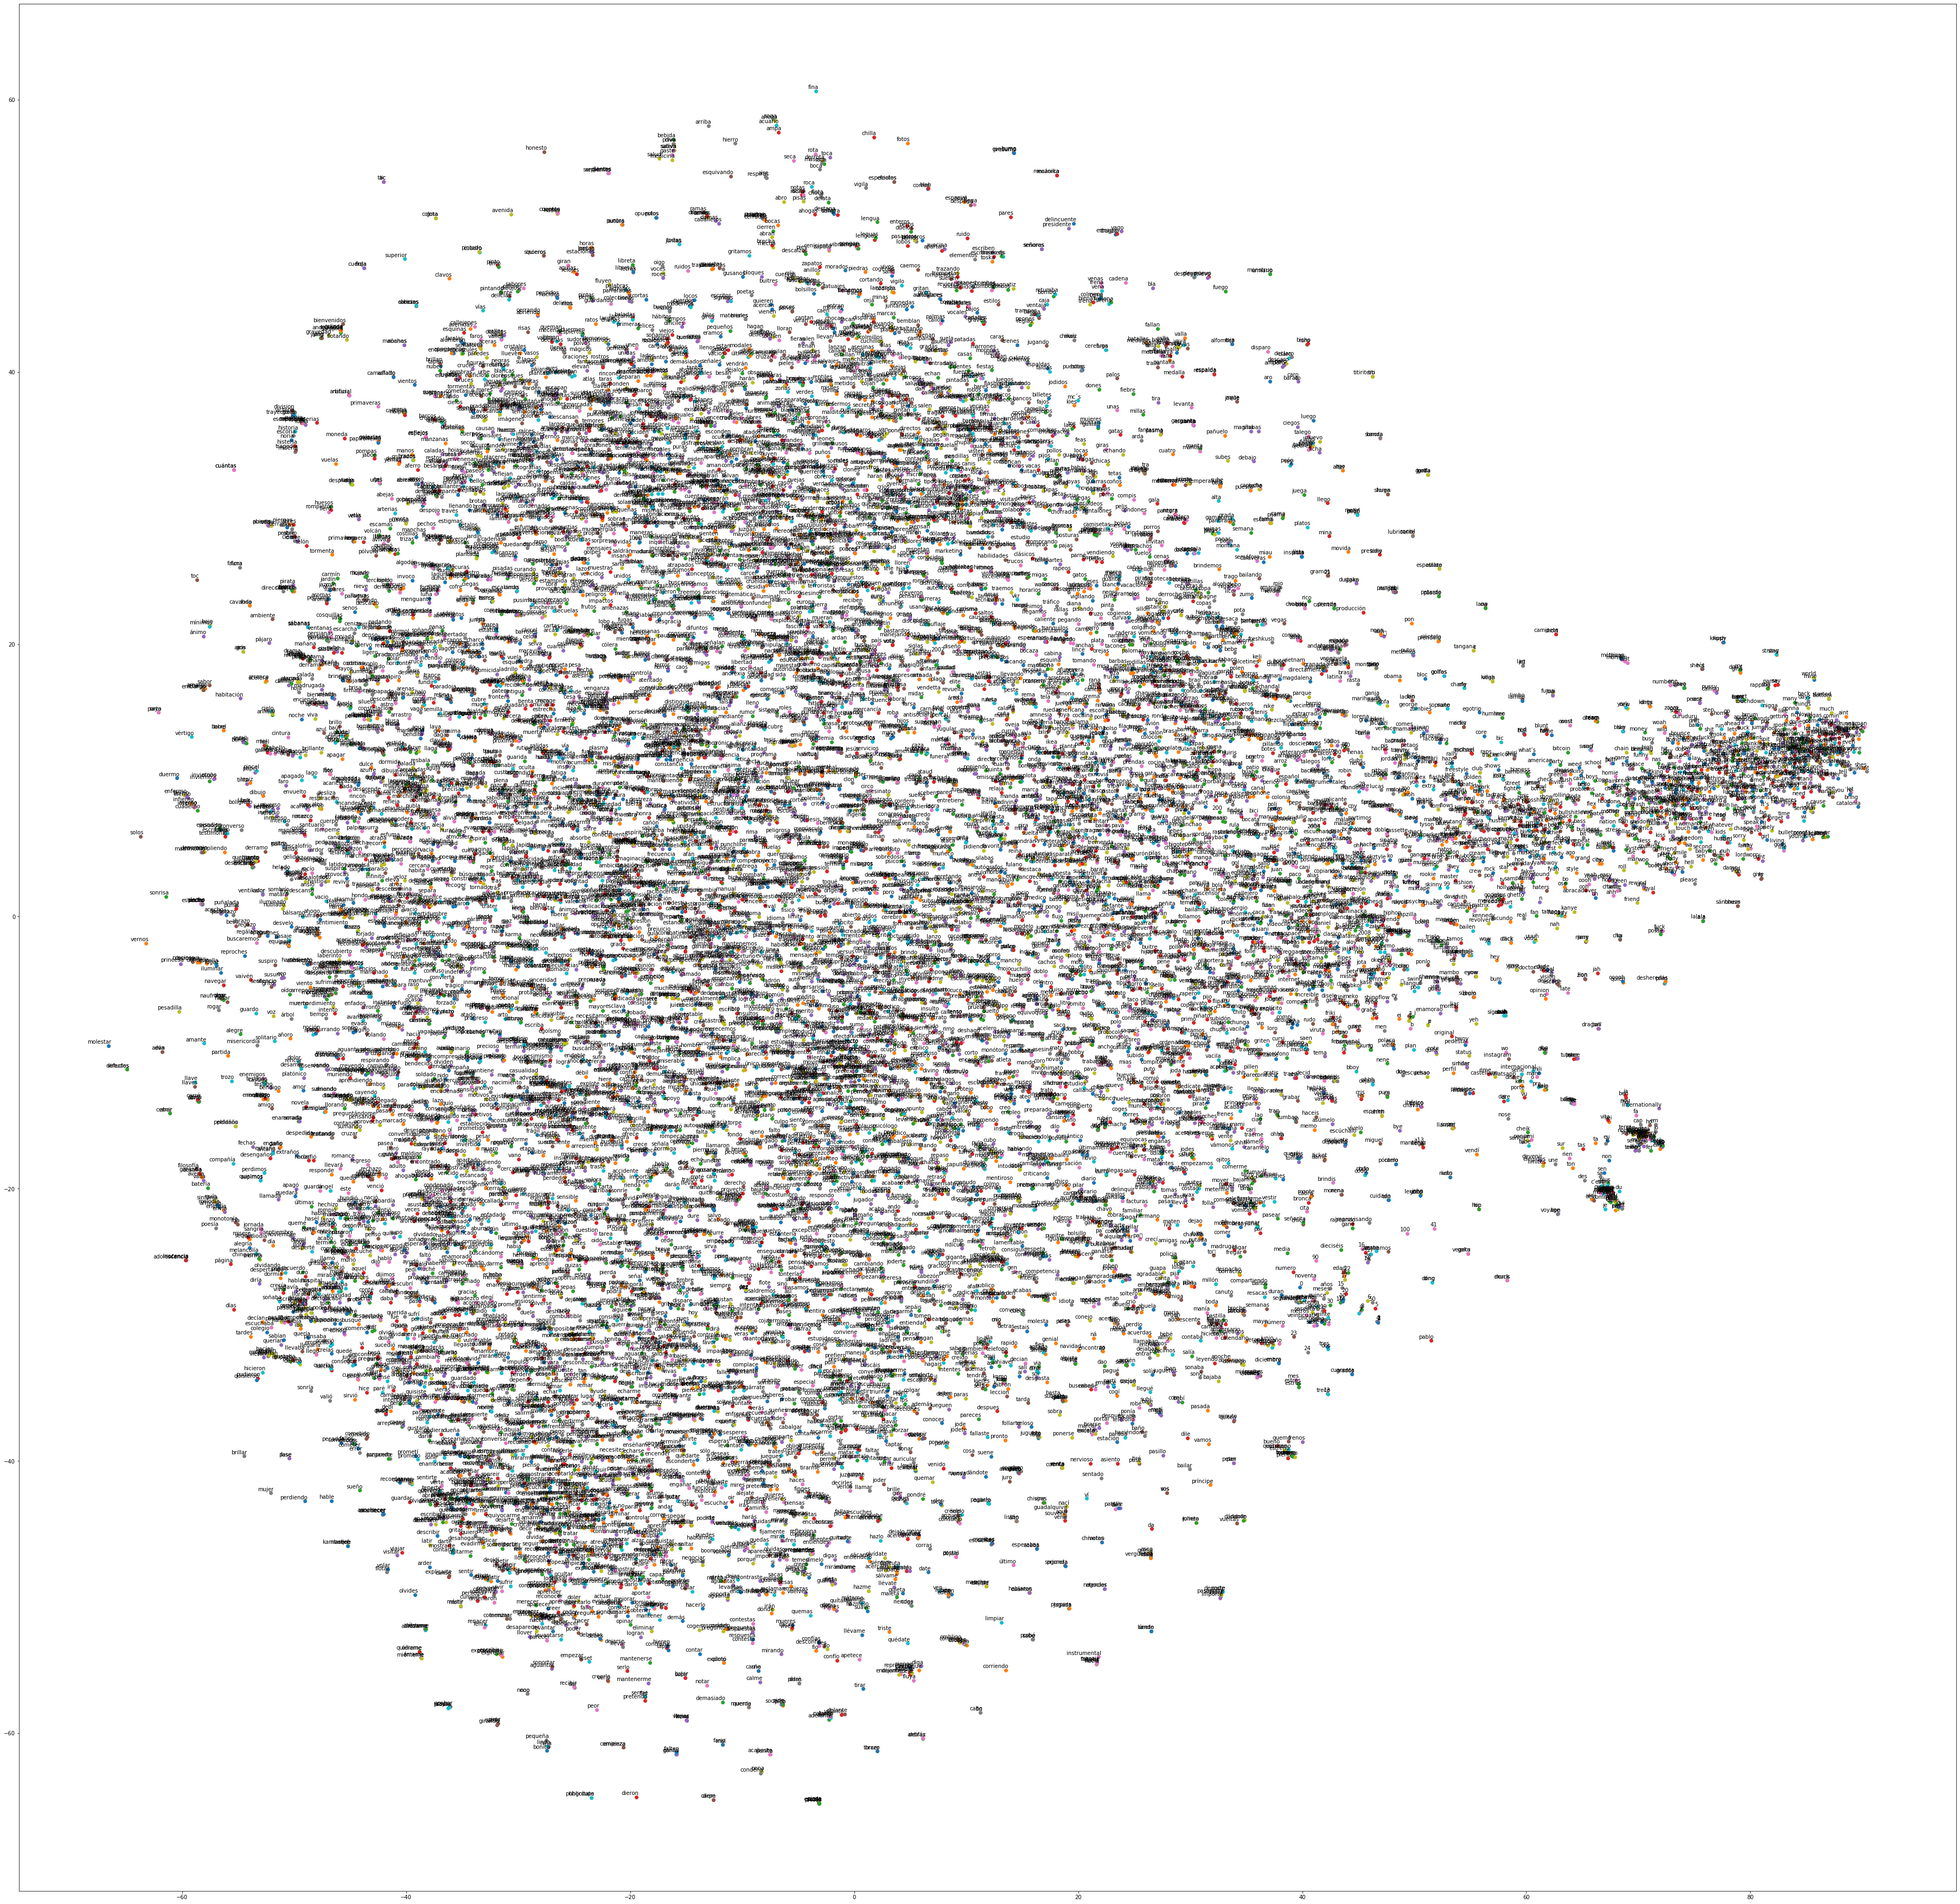

In [134]:
tsne_plot(model_sg)

## Visualizando el modelo en 2D con T-SNE (CBOW)

In [ ]:
tsne_plot(model_cbow)